# Introduction

# Problem Description:
### If someone is looking to open a restaurant in DENVER, where would you recommend that they open it?

# Background Discussion:
Since we do not have data regarding the relative financial success of various restaurants in the area, we will have to make an educated guess on what we should look for when searching for a location to open a new restaurant. Some reasonable factors to consider might be:
<ul><li>Total non-restaurant venues nearby (positive, indicates a busy area)</li>
    <li>Total other restaurants nearby (negative, potential for lost customers)</li>
    <li>Median income of neighborhood (positive, disposable income leads to eating out)</li>
    <li>Proximity to public transportation (positive, ease of access)</li>
    </ul>

We also need to frame the scale that we will be analyzing this problem at. Due to data availability, we will use zip/postalcode as our target dimension. Due to scope of the model, a centroid point will be used for each postalcode to estimate lat/long coordinates.

# Who Would Be Interested In This Project?:
The model might be useful to anyone interested in opening a restaurant in the Denver area. This could include individuals starting their first restaurant, current restaurant franchises looking to expand, or entrepreneurs looking to invest.

# Data Description:
Will be used for exploratory visualization as well as features for unsupervised machine learning. These raw numbers will be normalized for model input and weighted against the relative population of each zipcode.

<ul>
    <li>List of zipcodes in Denver Metro Area <a href="https://www.zipcodestogo.com/Colorado/">source</a></li>
    <li>Venues in each zipcode (source: FourSquare API)<li>
    <ul>Will be used for:
        <li>Total venues in radius</li>
        <li>Type of each</li>
    </ul>
    <li>Median income data, flattened by zipcode <a href="https://www.irs.gov/pub/irs-soi/16zp06co.xls">source</a></li>
    <li>List of public transportation stations <a href="https://opendata.arcgis.com/datasets/17749050721d427399ab4e038028929d_6.csv">source</a></li>
    <li>Population data <a href="https://s3.amazonaws.com/SplitwiseBlogJB/2010+Census+Population+By+Zipcode+(ZCTA).csv">source</a></li> </ul>

# Methodology:
Note: You will need to import your own FourSquare developer credentials to download venue data.

In [1]:
import sys, re
assert re.match('[\d\.]{3}', sys.version).group(0) > '3.6', \
"Upgrade your python to one that is able to create f-strings (3.6 or greater) or else this code will error"

#### Imports

In [2]:
%load_ext folium_magic
import folium, re, geocoder, requests, json, uszipcode, sklearn, branca
import pandas as pd, numpy as np, matplotlib as mpl, matplotlib.pyplot as plt
import matplotlib.cm as cm, matplotlib.colors as colors, matplotlib.image as mpimg
from pandas.io.json import json_normalize
from geopy.geocoders import Nominatim
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

#### Foursquare credentials

In [3]:
with open('/Users/kutch/Desktop/IBM/foursquarecreds.txt') as f:
    fsq = f.read()
client_id = re.search("(?<=CLIENT_ID)[ =]+'([A-Z0-9]+)", fsq).group(1)
client_sec = re.search("(?<=CLIENT_SECRET)[ =]+'([A-Z0-9]+)", fsq).group(1)
#not sure if coursera wants me to update this or not
VERSION = '20190501' # Foursquare API version
#from foursquare, function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

#### Get all zipcodes in city of Denver

In [4]:
zipsearch = uszipcode.SearchEngine(simple_zipcode=True)
all_zips = pd.read_html('https://www.zipcodestogo.com/Colorado/', 
             match='Zip Codes', 
             skiprows=range(3))[0]
all_zips = all_zips.drop(range(2,len(all_zips.columns)),axis=1)
all_zips.columns = ['Postalcode','City']
all_zips = all_zips.set_index('Postalcode')
denver_zips = all_zips[all_zips['City']=='Denver']

#### Append lat/long to zipcodes

In [5]:
ll_data = [[zipcode, zipsearch.by_zipcode(zipcode).lat, 
            zipsearch.by_zipcode(zipcode).lng] for zipcode in denver_zips.index]
ll_df = pd.DataFrame(data=ll_data, columns=['Postalcode','Latitude','Longitude']).dropna().set_index('Postalcode')
denver_zips = denver_zips.merge(ll_df,left_index=True,right_index=True)

#### Get population data
Important note: Census data cannot be mapped exactly to zip code (<a href="https://www.quora.com/Where-can-I-find-U-S-Census-data-with-population-per-ZIP-code-Other-details-such-as-age-gender-breakdown-would-be-helpful">see more</a>)

In [6]:
population = pd.read_csv("https://s3.amazonaws.com/SplitwiseBlogJB/2010+Census+Population+By+Zipcode+(ZCTA).csv")
population = population.rename(mapper={population.columns[0]:'Postalcode', 
                                       population.columns[1]:'Population'}, axis=1)
population = population.set_index('Postalcode')
population_denver = population.merge(denver_zips, 
                                     left_index=True, right_index=True).drop(denver_zips.columns, axis=1)

#### Get income data

In [7]:
income = pd.read_excel('https://www.irs.gov/pub/irs-soi/16zp06co.xls',
                   header=None,
                   indexcol=0,
                   skiprows=range(6),
                   usecols=range(3)).dropna()
income.columns = ['Postalcode','Income','NumPeople']
income = income[income['Income']!='Total']
for index, row in income.iterrows():
    if re.match('\.',str(row['NumPeople'])):
        income = income.drop(index)
income['NumPeople'] = income['NumPeople'].astype(float)
income = income.set_index('Postalcode')
#most common category
tgb = income.drop(['Income'],axis=1).groupby(by=['Postalcode']).max()
income = tgb.merge(income, on=['Postalcode'], suffixes=['_x',''])
income = income[income['NumPeople_x']==income['NumPeople']].drop(['NumPeople_x','NumPeople'], axis=1)
income_denver = income.merge(denver_zips, left_index=True, right_index=True).drop(denver_zips.columns, axis=1)
income_denver = income_denver.rename(mapper={'Income':'MedianIncomeBracket'},axis=1)
income_denver['MedianIncomeBracket'] = income_denver['MedianIncomeBracket'].astype('str')
income_denver = income_denver.replace({'under':'\ through\ '},regex=True)
income_denver = income_denver.groupby(by=income_denver.index).min()

#### Get public transportation data

In [8]:
lightrail = pd.read_csv('https://opendata.arcgis.com/datasets/17749050721d427399ab4e038028929d_6.csv')
lightrail = lightrail.rename(mapper={'ZIPCODE':'Postalcode', 'PID':'NumLightrailStations'},axis=1)
lightrail = pd.DataFrame(lightrail.groupby(by=['Postalcode']).count()['NumLightrailStations'])

#### Get venue data

In [9]:
#for a given list of zipcodes
def get_nearby_venues(zipcodes, latitudes, longitudes):
    radius, limit = 500, 100
    global client_id, client_sec
    venues_list=[]
    for name, lat, lng in zip(zipcodes, latitudes, longitudes):
        # create the API request URL
        base = 'https://api.foursquare.com/v2/venues/explore?&client_id='
        url = base+f'{client_id}&client_secret={client_sec}&v={VERSION}&ll={lat},{lng}&radius={radius}&limit={limit}'
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Zipcode', 
                  'ZipcodeLatitude', 
                  'ZipcodeLongitude', 
                  'Venue', 
                  'VenueLatitude', 
                  'VenueLongitude', 
                  'VenueCategory']
    return(nearby_venues)

#get venue info for all denver zipcodes
venues_denver = get_nearby_venues(zipcodes=pd.Series(denver_zips.index), 
                                  latitudes=denver_zips['Latitude'], 
                                  longitudes=denver_zips['Longitude'])
venues_denver = venues_denver.rename(mapper={'Zipcode':'Postalcode'},axis=1)

In [10]:
cat_url = "https://raw.githubusercontent.com/davidschneider04/Coursera_Capstone/master/RestaurantCategories.csv"
restaurant_categories = pd.read_csv(cat_url, encoding = 'latin-1')
restaurants_denver = venues_denver.merge(restaurant_categories, on='VenueCategory')
restaurants_denver = restaurants_denver.drop(['ZipcodeLatitude','ZipcodeLongitude'],axis=1)
restaurants_denver = restaurants_denver[['Postalcode','VenueCategory','Venue','VenueLatitude','VenueLongitude']]

### First, let's get a general sense of the distribution of restauarants in the area using Folium.

#### Create a map centered on Denver

In [11]:
def create_map_denver():
    location = Nominatim(user_agent="den_explorer").geocode("Denver, CO")
    latitude, longitude = location.latitude, location.longitude
    mapobj = folium.Map(location=[latitude, longitude], zoom_start=12)
    return mapobj
map_denver = create_map_denver()

#### Frame the zipcodes we are interested in. Information originally sourced from:
https://opendata.arcgis.com/datasets/6b6091f299204e4c9c406a624baf43e6_10.geojson

In [12]:
with open('/Users/kutch/Desktop/IBM/Colorado_ZIP_Code_Tabulation_Areas_ZCTA.geojson', 'r') as gjson:
    data = json.load(gjson)
tmp = data
dzips = list(denver_zips.index.astype('str').unique())
map_boundaries = {'type': 'FeatureCollection', 'features': []}
for item in tmp['features']:
    item['properties']['name'] = str(item['properties']['ZCTA5CE10'])
    zipcode = item['properties']['ZCTA5CE10']
    if zipcode in dzips:
        map_boundaries['features'].append(item)

In [13]:
def style_function(feature):
    return {
        'fillOpacity': 0.5,
        'weight': 1}

for feature in map_boundaries['features']:
    i=1
    geojson = folium.GeoJson(
        feature,
        name=f'mapfeature{i}',
        style_function=style_function
    ).add_to(map_denver)
    popup = folium.Popup(feature['properties']['name'])
    popup.add_to(geojson)
    geojson.add_to(map_denver)
    i+=1

#### Add restaurant markers to map

In [14]:
for lat, lng, label in zip(restaurants_denver['VenueLatitude'], 
                           restaurants_denver['VenueLongitude'], 
                           restaurants_denver['Venue']):
    label = folium.Popup(str(label), parse_html=True)
    restaurant_marker = folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False)
    restaurant_marker.add_to(map_denver)

#### Render the map (if viewing in pdf, download this file and view with a web browser: https://github.com/davidschneider04/Coursera_Capstone/blob/master/map_denver_restaurants_all.html)

In [15]:
#click a circle marker to see the name of the restaurant,
##a general area to see the zipcode
filepath = '/Users/kutch/Desktop/IBM/map_denver_restaurants_all.html'
map_denver.save(filepath)
map_denver

### Obviously, this is an incredibly complex problem and we could refine a model forever if the stakes here were higher and there were more resources available. For now, we will have to create a heuristic to simplify our process, our model, and its intepretation. 
In this hypothetical situation, let's say our restaurant is relatively upscale. From personal experience, I would say an oversimplified picture of a successful environment for this theoretical venue would be a location where potential customers have enough money to eat out often at our restaurant, and few enough restaurants nearby where we will not be competing for customers constantly. So, we will search for zipcodes that satisfy the following criteria:
<ul><li>Low restaurant:person ratio</li>
    <li>High median income</li></ul>

#### restaurant:person ratio

In [16]:
zipvenues_denver = venues_denver.set_index('Postalcode').groupby(by=['Postalcode']).count()['VenueCategory']
zipvenues_denver = pd.DataFrame(zipvenues_denver).rename(mapper={'VenueCategory':'TotalVenues'}, axis=1)
#restaurant density
rd_denver = zipvenues_denver.merge(population_denver, 
                                   left_index=True, right_index=True)
rd_denver['restaurant_density'] = rd_denver['TotalVenues'] / rd_denver['Population']
rd_denver = rd_denver.replace([np.inf], 0)
rd_denver = rd_denver.drop([col for col in rd_denver if col != 'restaurant_density'],
                           axis=1)
##remove outliers
tmp = rd_denver
outliers = ['80202']
tmp = tmp.loc[[i for i in tmp.index if str(i) not in outliers]]
##scale
mms = sklearn.preprocessing.MinMaxScaler()
tmp['restaurant_density'] = mms.fit_transform(tmp)
rd_denver = rd_denver.merge(tmp, how='left', 
                            left_index=True, right_index=True,
                            suffixes=('_x',''))
rd_denver = rd_denver.drop(columns=[col for col in rd_denver.columns if re.search('\_x',col)])
##add outliers back in
rd_denver = rd_denver.replace([np.nan], 1)

#### Create a combined dataset of zipcode attributes

In [17]:
#datasets: 
##denver_zips
##income_denver
##rd_denver
##lightrail
denver_data = denver_zips
#append income, inner join
denver_data = denver_data.merge(income_denver, left_index=True, right_index=True)
#append restaurant density, inner join
denver_data = denver_data.merge(rd_denver, left_index=True, right_index=True)
#append lightrail station data, left join bc we can assume 0 for missing values
##scale values for modeling
mms = sklearn.preprocessing.MinMaxScaler()
lightrail['ScaledLightrailStations'] = mms.fit_transform(lightrail)
lightrail = lightrail.drop(['NumLightrailStations'],axis=1)
denver_data = denver_data.merge(lightrail, how='left', left_index=True, right_index=True)
denver_data['ScaledLightrailStations'] = denver_data['ScaledLightrailStations'].replace([np.nan],0)

### Let's refresh our map with this new data
#### Shade zipcode polygons according to inverse restaurant density

In [18]:
map_denver = create_map_denver()
denver_data['restaurant_density_color'] = denver_data['restaurant_density'].astype('str')
denver_data['restaurant_density_color'] = denver_data['restaurant_density_color'].apply(mpl.colors.to_hex)

In [19]:
def style_function(feature):
    global denver_data
    color = denver_data.loc[int(feature['properties']['name'])]['restaurant_density_color']
    return {
        'fillColor': color,
        'color': color,
        'fillOpacity': 0.5,
        'weight': 1}

#### Only plot polygons for high-income zipcodes

In [20]:
i=1
for feature in map_boundaries['features']:
    zipcodeval = feature['properties']['name'] 
    if int(zipcodeval) in denver_data[~denver_data['MedianIncomeBracket'].isin(['$1 \\ through\\  $25,000'])].index:
        geojson = folium.GeoJson(
            feature,
            name=f'mapfeature{i}',
            style_function=style_function
        ).add_to(map_denver)
        popup = folium.Popup(zipcodeval)
        popup.add_to(geojson)
        geojson.add_to(map_denver)
        i+=1

#### Render the map (if viewing in pdf, download this file and view with a web browser: https://github.com/davidschneider04/Coursera_Capstone/blob/master/map_denver_high_income.html)

In [21]:
filepath = '/Users/kutch/Desktop/IBM/map_denver_high_income.html'
map_denver.save(filepath)
map_denver

#### It seems like the zipcode within the city proper that stands out the most is 80206. Let's see if we can confirm or deny our suspicions with an unsupervised machine learning model.

### Similarity Modeling
Suppose we do some more research, and we learn that many restaurants in a certain portion of town ("Highlands") are thriving (<a href="https://www.westword.com/restaurants/lohi-now-home-to-over-75-restaurants-and-brs-11258151">source</a>). But, we then find this research to be largely outdated and the area currently overpriced. Can we find a suitable substitute? Absent other data, this neighborhood can be our estimate of a good area to open a restaurant in. We can then use similarity modeling to find other areas in Denver that share the same features which make it favorable for restaurant development, but at a hopefully lower price. A <b>K-Means</b> model will allow us to create arbitrary clusters to find other zipcodes that are similar to the thriving Highlands neighborhood based on a mixture of our features.

#### "LoHi" is a neighborhood, but we've created our dataset at a zipcode level, so we need to standardize.
Using <a href="https://www.denvergov.org/maps/map/neighborhoods">this map</a>, we can see that the "Highlands" neighborhood is a subset of the <b>80211</b> zipcode. This means we will take the 80211 row of our "denver_data" DataFrame to represent a good spot for a restaurant going into our model.

#### Create formatted dataset for modeling

In [22]:
#create a dataset more appropriate for modeling
denver_data_model = denver_data
#not appropriate features
denver_data_model = denver_data_model.drop(['City','Latitude','Longitude','restaurant_density_color'], axis=1)
#reformat income data
##as ordinal
mapper = {'$1 \\ through\\  $25,000':1, '$25,000 \\ through\\  $50,000':2, '$100,000 \\ through\\  $200,000':3}
denver_data_model['MedianIncomeBracket'] = denver_data_model['MedianIncomeBracket'].replace(mapper)
##scaled
mms = sklearn.preprocessing.MinMaxScaler()
mi = pd.DataFrame(denver_data_model['MedianIncomeBracket'])
mi['ScaledMedianIncomeBracket'] = mms.fit_transform(mi)
mi = mi.drop(['MedianIncomeBracket'], axis=1)
##combine
denver_data_model = denver_data_model.merge(mi, left_index=True, right_index=True)
denver_data_model = denver_data_model.drop(['MedianIncomeBracket'],axis=1)

#### Let's inspect the dataset to ensure it's appropriate

In [23]:
print(denver_data_model.shape)
denver_data_model.head()

(39, 3)


,restaurant_density,ScaledLightrailStations,ScaledMedianIncomeBracket
Postalcode,,,
80202,1.000000,0.555556,0.5
80203,0.894294,0.000000,0.5
80204,0.267482,1.000000,0.0
80205,0.205914,0.333333,0.0
80206,0.083876,0.000000,0.5


#### Find optimal value for k

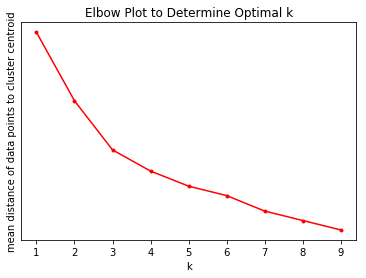

In [24]:
distortions = []
krange = range(1,10)
for k in krange:
    kmeanModel = KMeans(n_clusters=k).fit(denver_data_model)
    kmeanModel.fit(denver_data_model)
    distortions.append(sum(np.min(cdist(denver_data_model, kmeanModel.cluster_centers_, 'euclidean'), 
                                  axis=1)) / denver_data_model.shape[0])

#elbow plot
plt.plot(krange, distortions, 'r.-')
plt.xlabel('k')
plt.ylabel('mean distance of data points to cluster centroid')
plt.title('Elbow Plot to Determine Optimal k')
plt.yticks([])
plt.show()

#### k=4
It seems like the slope of the line tangent to the curve of the mean point:centroid distance slows its decrease around k=4; we will choose this as the number of clusters to use when building the final k-means model

#### K-means model

In [25]:
kval = 4
#sort the dataset
denver_data_model = denver_data_model.sort_values(by=['restaurant_density',
                                                      'ScaledLightrailStations',
                                                      'ScaledMedianIncomeBracket'],ascending=False)
denver_data_clustering = denver_data_model
denver_data_clustering = denver_data_clustering.reset_index().drop(['Postalcode'], axis=1)
kmm = KMeans(n_clusters=kval, random_state=0).fit(denver_data_clustering)

#### Insert cluster labels back and index at 1

In [26]:
denver_data_model['cluster_label'] = [label+1 for label in kmm.labels_]

#### Profile the clusters so we can give them descriptions

In [27]:
cluster_info = denver_data_model.reset_index()
cluster_info = cluster_info.drop(['Postalcode'], axis=1)
cluster_info = cluster_info.set_index(['cluster_label'])
cluster_info = cluster_info.groupby(cluster_info.index).mean()
cluster_info

,restaurant_density,ScaledLightrailStations,ScaledMedianIncomeBracket
cluster_label,,,
1,0.127894,0.033816,0.000000
2,0.267482,1.000000,0.000000
3,0.256275,0.027778,0.562500
4,0.785659,0.126984,0.142857


#### We can subjectively judge the following and use the statistics to create labels:
<ol><li> Restaurants: medium, Lightrails: high, Income: low. <b>Label:</b> Accessible</li>
    <li> Restaurants: medium, Lightrails: low, Income: high <b>Label:</b> High Income</li>
    <li> Restaurants: low, Lightrails: low, Income: low <b>Label:</b> Underdeveloped</li>
    <li> Restaurants: high, Lightrails: medium, Income: medium. <b>Label:</b> Crowded</li>  
    </ol>

In [28]:
#assign the labels
mapper = {1:'Accessible', 2:'High Income', 3:'Underdeveloped', 4:'Crowded'}
denver_data_model['cluster_label'] = denver_data_model['cluster_label'].replace(mapper)

#### Add location data back in so we can visualize the clusters

In [29]:
denver_data_modelplot = denver_data_model.merge(denver_data, 
                                            left_index=True, right_index=True
                                           ,suffixes=('_x',''))

In [30]:
denver_data_modelplot = denver_data_modelplot.drop([col 
                                                    for col in denver_data_modelplot.columns 
                                                    if re.search('(\_x)|(color)', col)],axis=1)
denver_data_modelplot = denver_data_modelplot.drop(['MedianIncomeBracket'],axis=1)

#### Set color scheme for the clusters

In [31]:
x = np.arange(kval)
ys = [i + x + (i*x)**2 for i in range(kval)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
rainbowdict = {i:color for (i, color) in enumerate(rainbow)}
clustermapper = {value: key for key, value in mapper.items()}

In [32]:
denver_data_modelplot['cluster_code'] = denver_data_modelplot['cluster_label'].map(clustermapper)-1
denver_data_modelplot['cluster_color'] = denver_data_modelplot['cluster_code'].map(rainbowdict)

#### Create a new map to show clusters

In [33]:
map_denver = create_map_denver()

In [34]:
def style_function(feature):
    global denver_data_modelplot
    color = denver_data_modelplot.loc[int(feature['properties']['name'])]['cluster_color']
    return {
        'fillColor': color,
        'color': color,
        'fillOpacity': 0.5,
        'weight': 1}

i=1
for feature in map_boundaries['features']:
    zipcodeval = feature['properties']['name']
    if int(zipcodeval) in list(denver_data_modelplot.index):
        geojson = folium.GeoJson(
            feature,
            name=f'mapfeature{i}',
            style_function=style_function
        ).add_to(map_denver)
        popup = folium.Popup(zipcodeval)
        popup.add_to(geojson)
        geojson.add_to(map_denver)
        i+=1

#### Create a legend

In [35]:
legend_html_base = f"""
     <div style="position: fixed; 
     bottom: 50px; left: 50px; width: 150px; height: 125px; 
     border:2px solid grey; z-index:9999; font-size:12px; background:white;
     ">&nbsp; <b>Legend</b> <br>
     &nbsp;"""
for cluster in list(denver_data_modelplot['cluster_label'].unique()):
    color = denver_data_modelplot[denver_data_modelplot['cluster_label']==cluster]['cluster_color'].iloc[0]
    legend_html_base+=f"""{cluster} &nbsp; <i class="fa fa-map-marker fa-2x" style="color:{color}"></i><br> &nbsp;"""
legend_html = legend_html_base + """</div>"""
map_denver.get_root().html.add_child(folium.Element(legend_html))

#### Render the map (if viewing in pdf, download this file and view with a web browser: https://github.com/davidschneider04/Coursera_Capstone/blob/master/map_denver_clusters.html)

In [36]:
filepath = '/Users/kutch/Desktop/IBM/map_denver_clusters.html'
map_denver.save(filepath)
map_denver

#### While the colors of our clusters on the map are arbitrary, it is a happy coincidence for implicit understanding that red represents the color of the presumably least desirable cluster-- "Crowded" (with other restaruants)

#### Create the map again, but this time only with zipcodes matching the cluster for 80211.

In [37]:
map_denver = create_map_denver()
tc = denver_data_modelplot.loc[80211]['cluster_label']
i=1
for feature in map_boundaries['features']:
    zval = int(feature['properties']['name'])
    if zval in list(denver_data_modelplot.index) and denver_data_modelplot.loc[zval]['cluster_label'] == tc:
        geojson = folium.GeoJson(
            feature,
            name=f'mapfeature{i}',
            style_function=style_function
        ).add_to(map_denver)
        popup = folium.Popup(str(zval))
        popup.add_to(geojson)
        geojson.add_to(map_denver)
        i+=1

#### Render the map (if viewing in pdf, download this file and view with a web browser: https://github.com/davidschneider04/Coursera_Capstone/blob/master/map_denver_restaurants_cluster_filter.html)

In [38]:
filepath = '/Users/kutch/Desktop/IBM/map_denver_restaurants_cluster_filtered.html'
map_denver.save(filepath)
map_denver

#### For reference, here are all of the zipcodes within the cluster we are interested in:

In [39]:
denver_data_modelplot[denver_data_modelplot['cluster_label']==denver_data_modelplot.loc[80211]['cluster_label']]

,ScaledMedianIncomeBracket,cluster_label,City,Latitude,Longitude,restaurant_density,ScaledLightrailStations,cluster_code,cluster_color
Postalcode,,,,,,,,,
80230,0.0,Accessible,Denver,39.72,-104.89,0.398002,0.000000,0,#8000ff
80211,0.0,Accessible,Denver,39.76,-105.02,0.361976,0.000000,0,#8000ff
80236,0.0,Accessible,Denver,39.65,-105.03,0.335874,0.000000,0,#8000ff
80235,0.0,Accessible,Denver,39.65,-105.09,0.238423,0.000000,0,#8000ff
80205,0.0,Accessible,Denver,39.76,-104.97,0.205914,0.333333,0,#8000ff
80247,0.0,Accessible,Denver,39.69,-104.88,0.165504,0.000000,0,#8000ff
80219,0.0,Accessible,Denver,39.71,-105.03,0.137428,0.000000,0,#8000ff
80222,0.0,Accessible,Denver,39.67,-104.93,0.119902,0.111111,0,#8000ff
80216,0.0,Accessible,Denver,39.79,-104.95,0.110161,0.111111,0,#8000ff


#### If we want, we can join back to the original venues dataframe to get a more granular look now that we have filtered the number of data points down to a more manageable amount and do more data exploration based on that. We will create this dataframe, but leave the investigation of specific places for another time.

In [40]:
vdtmp = venues_denver
vdtmp = vdtmp.set_index('Postalcode')
potential_competitors = denver_data_modelplot.merge(vdtmp,left_index=True,right_index=True)
#reorder columns, drop unnecessary columns
potential_competitors = potential_competitors[['VenueCategory','Venue','VenueLatitude','VenueLongitude'
                                              ,'ScaledMedianIncomeBracket','cluster_label',
                                               'restaurant_density','ScaledLightrailStations']]
potential_competitors = potential_competitors.sort_values(by=['Postalcode', 'VenueCategory','Venue'])
potential_competitors.head()

,VenueCategory,Venue,VenueLatitude,VenueLongitude,ScaledMedianIncomeBracket,cluster_label,restaurant_density,ScaledLightrailStations
Postalcode,,,,,,,,
80202,Accessories Store,Timbuk2,39.747552,-104.999613,0.5,Crowded,1.0,0.555556
80202,Alternative Healer,LoDo Wellness Center,39.751730,-104.999869,0.5,Crowded,1.0,0.555556
80202,American Restaurant,Euclid Hall Bar & Kitchen,39.747577,-105.000243,0.5,Crowded,1.0,0.555556
80202,American Restaurant,Freshcraft,39.750012,-104.999685,0.5,Crowded,1.0,0.555556
80202,American Restaurant,Nickel,39.746145,-104.998202,0.5,Crowded,1.0,0.555556


# Results

The results of the model do/do not support my initial hypothesis that 80206 would be clustered similarly to 80211. However, it does highlight some other zipcodes which are modeled to be similar to 80211 based on the considered features. While we can see with the map that these zones often quickly extend outside the boundaries of Denver proper, which would likely disqualify them from our use case here, there are still a few of interest, most notably:
<ul><li>80205</li>
    <li>80207</li>
    <li>80220</li></ul>

# Discussion

While the model does not provide any single definitive "answer" for where an interested party should proceed to open a prospective restaurant, it is a useful tool for conducting their research more efficiently. The model highlights a subset of more eligible starting points than random chance, and also provides context for some of the features which might be influential or at least commonly associated with restaurant success.